# Backtesting Mercury Challenge Time Series Baserate Models

This notebook illustrates a backtest of the Mercury Challenge Baserate models for the Case Count events.  See [Developing Mercury Time Series Models](./Fit%20CU%20Time%20Series%20Models.ipynb) for model development details.

In [1]:
pwd

'/Users/peterhaglich/Dropbox/Work/IARPA/Mercury/peterhaglich/mercury-challenge/src/Baserate/notebooks'

In [2]:
%matplotlib inline

In [3]:
import os
import json
import pandas as pd
import numpy as np
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import (plot_acf, plot_pacf)
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_squared_error
import datetime
from dateutil.parser import parse
import sys
sys.path.append(("../.."))
from Baserate.main.timeseries import (
    evaluate_arima_model, 
    evaluate_models, 
    mean_qs_error, 
    TsDefaults,
    one_step_ahead_forecast,
    hist_avg_predict,
    future_dates
)
from ExpressScore.main.express_score import CaseCountScorer
import warnings
warnings.filterwarnings("ignore")

import matplotlib
import matplotlib.pyplot as plt
matplotlib.style.use("fivethirtyeight");

/anaconda3/envs/mercury/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [4]:
EVT_ABBR = "CU"
MC_HOME = os.path.abspath("../../..")
DOC_PATH = os.path.join(MC_HOME, "doc")
EVT_DOC_PATH = os.path.join(DOC_PATH, "scoring", EVT_ABBR)
DATA_PATH = os.path.join(MC_HOME, "data")
GSR_PATH = os.path.join(DATA_PATH, "gsr")
CU_COUNT_GSR_PATH = os.path.join(GSR_PATH, "cu_count_gsr")
WARN_PATH = os.path.join(DATA_PATH, "baserate_warnings")
CU_WARN_PATH = os.path.join(WARN_PATH, "baserate_cu_warnings")
RESOURCE_PATH = os.path.join(MC_HOME, "src", "Baserate", "resources")
MODEL_EVAL_FILENAME = "CU TS Model Parameters.json"
model_eval_filepath = os.path.join(RESOURCE_PATH, MODEL_EVAL_FILENAME)
with open(model_eval_filepath, "r") as f:
    model_eval_dict = json.load(f)
TRAIN_START_DATE = "2015-05-01"
TEST_START_DATE = "2018-08-01"
TEST_END_DATE = "2018-08-31"
test_range = pd.date_range(TEST_START_DATE, TEST_END_DATE)
test_months = [dd.strftime("%B_%Y") for dd in test_range]
test_months = list(pd.Series(test_months).unique())
PARTICIPANT_ID = "Mercury_Baserate"

In [5]:
test_months

['August_2018']

## Egypt Daily CU

In [6]:
place, freq = ("Egypt", "Daily")
model_details = model_eval_dict[place]
print(model_details)

{'Order': [2, 0, 1], 'Model_Params': [5.348368567013427, 1.3043697162287806, -0.3267554866621827, -0.8888925988013819], 'Error': 0.4152948681735336}


A plot of the case counts over time is shown below.

Data from 2015-05-01 00:00:00 to 2018-08-21 00:00:00


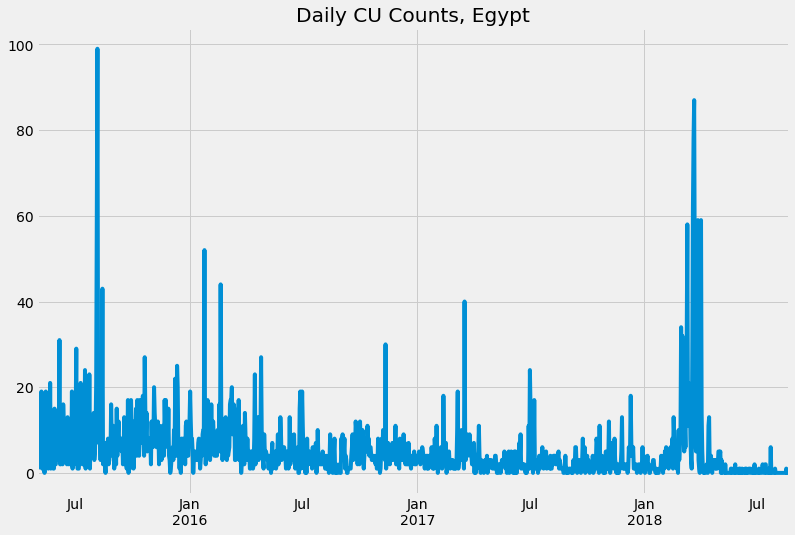

In [7]:
filename_ = "{0}_{1}_Counts.json".format(place, freq)
filepath_ = os.path.join(CU_COUNT_GSR_PATH, filename_)
with open(filepath_, "r", encoding="utf8") as f:
    gsr_ = json.load(f)
count_dict = {parse(e["Event_Date"]): e["Case_Count"] for e in gsr_}
count_ser = pd.Series(count_dict)
count_ser.plot(figsize=(12,8))
print("Data from {0} to {1}".format(count_ser.index[0], count_ser.index[-1]))
plt.title("{0} CU Counts, {1}".format(freq, place));

Backtest using January - June 2018

August_2018
Fitting ARIMA with order [2, 0, 1]
Mean QS = 0.369


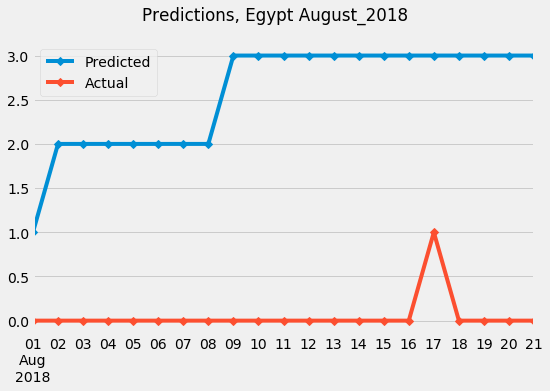

In [8]:
mm_ser = pd.Series({dd: dd.strftime("%B_%Y") for dd in count_ser.index})
count_df = pd.DataFrame({"Actual": count_ser,
                         "Month": mm_ser})

for mm in test_months:
    print(mm)
    test_start_date = parse(" ".join(mm.split("_"))).replace(day=1)
    train = count_df[:test_start_date]
    test = count_df[count_df.Month == mm]
    order = model_eval_dict[place]["Order"]
    if order != [0,0,0]:
        print("Fitting ARIMA with order", order)
        model = sm.tsa.ARIMA(endog=train.Actual, order=order)
        model_fit = model.fit(disp=0)
        predict = model_fit.forecast(steps=len(test))[0]
    else:
        historical_mean = train.Actual.mean()
        predict = [historical_mean]*len(test)
    predict = [round(p) for p in predict]
    predict_ser = pd.Series(predict, index=test.index)
    predict_df = pd.DataFrame({"Predicted": predict_ser,
                               "Actual": test.Actual})
    predict_df["Quality_Score"] = predict_df.apply(lambda x: CaseCountScorer.quality_score(x.Predicted, 
                                                                                           x.Actual),
                                                   axis=1)
    qs_mean = predict_df.Quality_Score.mean()
    print("Mean QS = {:.3f}".format(qs_mean))
    predict_df["Event_Date"] = predict_df.index
    predict_df["Event_Type"] = "Civil Unrest"
    #print(predict_df)

    fig, ax = plt.subplots(1,1, figsize = (8,5))
    predict_df[["Predicted", "Actual"]].plot(marker="D", ax=ax)
    fig.suptitle("Predictions, {0} {1}".format(place, mm))
    #plt.title(plt_title)
    plot_place_path = os.path.join(EVT_DOC_PATH, place)
    plot_filename = "GSR and BR Warnings {0} {1}.png".format(place, mm)
    plot_path = os.path.join(plot_place_path, plot_filename)
    fig.savefig(plot_path)
    br_output_df = predict_df[["Event_Type", "Event_Date"]]
    br_output_df["Case_Count"] = predict_df.Predicted
    br_output_df["Country"] = place
    br_output_df["Warning_ID"] = br_output_df.apply(lambda x: "BR_CU_{0}_{1}".format(place, 
                                                                            x.Event_Date.strftime("%Y-%m-%d")),
                                                    axis=1)
    #print(br_output_df.head(2))
    out_filename = "BR_Warnings_{0}_{1}.json".format(place, mm)
    out_path = os.path.join(CU_WARN_PATH, place, out_filename)
    out_json = br_output_df.to_json(force_ascii=False, orient="records", 
                                    date_format="iso", path_or_buf=out_path)
    with open(out_path, "r", encoding="utf8") as f:
        warn_json = json.load(f)
    #print(warn_json)
    for k in warn_json:
        k["Event_Date"] = k["Event_Date"][:10]
        # k["Model_Details"] = model_details 
    warn_json = {"participant_id": PARTICIPANT_ID, "payload": warn_json}
    with open(out_path, "w") as f:
        json.dump(warn_json, f, ensure_ascii=False, indent=2)



In [9]:
freq = "Weekly"

## Tahrir Weekly CU

In [10]:
place = "Tahrir"
model_details = model_eval_dict[place]
print(model_details)

{'Order': [1, 0, 3], 'Model_Params': [13.219405392902976, 0.6914315123177581, -0.1998999938525163, -0.15440225073141006, 0.22803605306536565], 'Error': 0.45546648460232236}


Data from 2015-04-29 00:00:00 to 2018-08-15 00:00:00


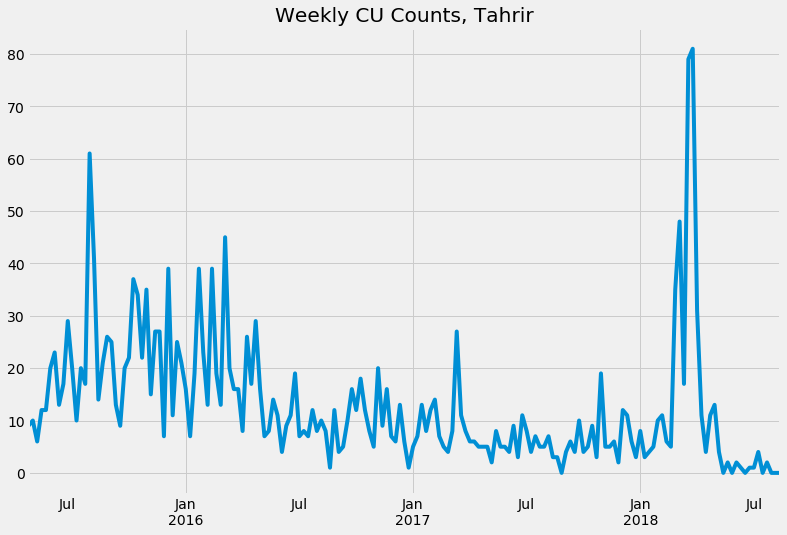

In [11]:
filename_ = "{0}_{1}_Counts.json".format(place, freq)
filepath_ = os.path.join(CU_COUNT_GSR_PATH, filename_)
with open(filepath_, "r", encoding="utf8") as f:
    gsr_ = json.load(f)
count_dict = {parse(e["Event_Date"]): e["Case_Count"] for e in gsr_}
count_ser = pd.Series(count_dict)
count_ser.plot(figsize=(12,8))
print("Data from {0} to {1}".format(count_ser.index[0], count_ser.index[-1]))
plt.title("{0} CU Counts, {1}".format(freq, place));

In [12]:
mm_ser = pd.Series({dd: dd.strftime("%B_%Y") for dd in count_ser.index})
count_df = pd.DataFrame({"Actual": count_ser,
                         "Month": mm_ser})

for mm in test_months:
    print(mm)
    test_start_date = parse(" ".join(mm.split("_"))).replace(day=1)
    train = count_df[:test_start_date]
    test = count_df[count_df.Month == mm]
    order = model_eval_dict[place]["Order"]
    if order != [0,0,0]:
        print("Fitting ARIMA with order", order)
        model = sm.tsa.ARIMA(endog=train.Actual, order=order)
        model_fit = model.fit(disp=0)
        predict = model_fit.forecast(steps=len(test))[0]
    else:
        historical_mean = train.Actual.mean()
        predict = [historical_mean]*len(test)
    predict = [round(p) for p in predict]
    predict_ser = pd.Series(predict, index=test.index)
    predict_df = pd.DataFrame({"Predicted": predict_ser,
                               "Actual": test.Actual})
    predict_df["Quality_Score"] = predict_df.apply(lambda x: CaseCountScorer.quality_score(x.Predicted, 
                                                                                           x.Actual),
                                                   axis=1)
    qs_mean = predict_df.Quality_Score.mean()
    print("Mean QS = {:.3f}".format(qs_mean))
    predict_df["Event_Date"] = predict_df.index
    predict_df["Event_Type"] = "Civil Unrest"
    #print(predict_df)

    fig, ax = plt.subplots(1,1, figsize = (8,5))
    predict_df[["Predicted", "Actual"]].plot(marker="D", ax=ax)
    fig.suptitle("Predictions, {0} {1}".format(place, mm))
    #plt.title(plt_title)
    plot_place_path = os.path.join(EVT_DOC_PATH, place)
    plot_filename = "GSR and BR Warnings {0} {1}.png".format(place, mm)
    plot_path = os.path.join(plot_place_path, plot_filename)
    fig.savefig(plot_path)
    br_output_df = predict_df[["Event_Type", "Event_Date"]]
    br_output_df["Case_Count"] = predict_df.Predicted
    br_output_df["Country"] = "Egypt"
    br_output_df["City"] = "Tahrir Square"
    br_output_df["Warning_ID"] = br_output_df.apply(lambda x: "BR_CU_{0}_{1}".format(place, 
                                                                            x.Event_Date.strftime("%Y-%m-%d")),
                                                    axis=1)
    #print(br_output_df.head(2))
    out_filename = "BR_Warnings_{0}_{1}.json".format(place, mm)
    out_path = os.path.join(CU_WARN_PATH, place, out_filename)
    out_json = br_output_df.to_json(force_ascii=False, orient="records", 
                                    date_format="iso", path_or_buf=out_path)
    with open(out_path, "r", encoding="utf8") as f:
        warn_json = json.load(f)
    #print(warn_json)
    for k in warn_json:
        k["Event_Date"] = k["Event_Date"][:10]
        # k["Model_Details"] = model_details 
    warn_json = {"participant_id": PARTICIPANT_ID, "payload": warn_json}
    with open(out_path, "w") as f:
        json.dump(warn_json, f, ensure_ascii=False, indent=2)




August_2018
Fitting ARIMA with order [1, 0, 3]


ValueError: The computed initial AR coefficients are not stationary
You should induce stationarity, choose a different model order, or you can
pass your own start_params.

## Jordan Weekly CU

In [ ]:
place = "Jordan"
model_details = model_eval_dict[place]
print(model_details)

In [ ]:
filename_ = "{0}_{1}_Counts.json".format(place, freq)
filepath_ = os.path.join(CU_COUNT_GSR_PATH, filename_)
with open(filepath_, "r", encoding="utf8") as f:
    gsr_ = json.load(f)
count_dict = {parse(e["Event_Date"]): e["Case_Count"] for e in gsr_}
count_ser = pd.Series(count_dict)
count_ser.plot(figsize=(12,8))
print("Data from {0} to {1}".format(count_ser.index[0], count_ser.index[-1]))
plt.title("{0} CU Counts, {1}".format(freq, place));

In [ ]:
mm_ser = pd.Series({dd: dd.strftime("%B_%Y") for dd in count_ser.index})
count_df = pd.DataFrame({"Actual": count_ser,
                         "Month": mm_ser})

for mm in test_months:
    print(mm)
    test_start_date = parse(" ".join(mm.split("_"))).replace(day=1)
    train = count_df[:test_start_date]
    test = count_df[count_df.Month == mm]
    order = model_eval_dict[place]["Order"]
    if order != [0,0,0]:
        print("Fitting ARIMA with order", order)
        model = sm.tsa.ARIMA(endog=train.Actual.apply(lambda x: float(x)), 
                                                      order=order)
        model_fit = model.fit(disp=0)
        predict = model_fit.forecast(steps=len(test))[0]
    else:
        historical_mean = train.Actual.mean()
        predict = [historical_mean]*len(test)
    predict = [round(p) for p in predict]
    predict_ser = pd.Series(predict, index=test.index)
    predict_df = pd.DataFrame({"Predicted": predict_ser,
                               "Actual": test.Actual})
    predict_df["Quality_Score"] = predict_df.apply(lambda x: CaseCountScorer.quality_score(x.Predicted, 
                                                                                           x.Actual),
                                                   axis=1)
    qs_mean = predict_df.Quality_Score.mean()
    print("Mean QS = {:.3f}".format(qs_mean))
    predict_df["Event_Date"] = predict_df.index
    predict_df["Event_Type"] = "Civil Unrest"
    #print(predict_df)

    fig, ax = plt.subplots(1,1, figsize = (8,5))
    predict_df[["Predicted", "Actual"]].plot(marker="D", ax=ax)
    fig.suptitle("Predictions, {0} {1}".format(place, mm))
    #plt.title(plt_title)
    plot_place_path = os.path.join(EVT_DOC_PATH, place)
    plot_filename = "GSR and BR Warnings {0} {1}.png".format(place, mm)
    plot_path = os.path.join(plot_place_path, plot_filename)
    fig.savefig(plot_path)
    br_output_df = predict_df[["Event_Type", "Event_Date"]]
    br_output_df["Case_Count"] = predict_df.Predicted
    br_output_df["Country"] = place
    br_output_df["Warning_ID"] = br_output_df.apply(lambda x: "BR_CU_{0}_{1}".format(place, 
                                                                            x.Event_Date.strftime("%Y-%m-%d")),
                                                    axis=1)
    #print(br_output_df.head(2))
    out_filename = "BR_Warnings_{0}_{1}.json".format(place, mm)
    out_path = os.path.join(CU_WARN_PATH, place, out_filename)
    out_json = br_output_df.to_json(force_ascii=False, orient="records", 
                                    date_format="iso", path_or_buf=out_path)
    with open(out_path, "r", encoding="utf8") as f:
        warn_json = json.load(f)
    #print(warn_json)
    for k in warn_json:
        k["Event_Date"] = k["Event_Date"][:10]
        # k["Model_Details"] = model_details 
    warn_json = {"participant_id": PARTICIPANT_ID, "payload": warn_json}
    with open(out_path, "w") as f:
        json.dump(warn_json, f, ensure_ascii=False, indent=2)





In [ ]:
freq = "Monthly"

## Amman Monthly CU

In [ ]:
place="Amman"
model_details = model_eval_dict[place]
print(model_details)

In [ ]:
filename_ = "{0}_{1}_Counts.json".format(place, freq)
filepath_ = os.path.join(CU_COUNT_GSR_PATH, filename_)
with open(filepath_, "r", encoding="utf8") as f:
    gsr_ = json.load(f)
count_dict = {parse(e["Event_Date"]): e["Case_Count"] for e in gsr_}
count_ser = pd.Series(count_dict)
count_ser.plot(figsize=(12,8))
print("Data from {0} to {1}".format(count_ser.index[0], count_ser.index[-1]))
plt.title("{0} CU Counts, {1}".format(freq, place));

In [ ]:
mm_ser = pd.Series({dd: dd.strftime("%B_%Y") for dd in count_ser.index})
count_df = pd.DataFrame({"Actual": count_ser,
                         "Month": mm_ser})
predict_dict = dict()

for mm in test_months:
    print(mm)
    test_start_date = parse(" ".join(mm.split("_")))
    test_start_date = test_start_date.replace(day=1)
    train = count_df[:test_start_date]
    test = count_df[count_df.Month == mm]
    order = model_eval_dict[place]["Order"]
    if order != [0,0,0]:
        print("Fitting ARIMA with order", order)
        model = sm.tsa.ARIMA(endog=train.Actual, order=order)
        model_fit = model.fit(disp=0)
        predict = model_fit.forecast(steps=len(test))[0]
    else:
        historical_mean = train.Actual.mean()
        predict = [historical_mean]*len(test)
    predict = [round(p) for p in predict]
    predict_ser = pd.Series(predict, index=test.index)
    predict_df = pd.DataFrame({"Predicted": predict_ser,
                               "Actual": test.Actual})
    predict_dict[test_start_date] = {"Predicted": predict[0],
                        "Actual": test.Actual[0]}
    predict_df["Quality_Score"] = predict_df.apply(lambda x: CaseCountScorer.quality_score(x.Predicted, 
                                                                                           x.Actual),
                                                   axis=1)
    qs_mean = predict_df.Quality_Score.mean()
    print("Mean QS = {:.3f}".format(qs_mean))
    predict_df["Event_Date"] = predict_df.index
    predict_df["Event_Type"] = "Civil Unrest"
    #print(predict_df)

    br_output_df = predict_df[["Event_Type", "Event_Date"]]
    br_output_df["Case_Count"] = predict_df.Predicted
    br_output_df["Country"] = "Jordan"
    br_output_df["State"] = place
    br_output_df["Warning_ID"] = br_output_df.apply(lambda x: "BR_CU_{0}_{1}".format(place, 
                                                                            x.Event_Date.strftime("%Y-%m-%d")),
                                                    axis=1)
    #print(br_output_df.head(2))
    out_filename = "BR_Warnings_{0}_{1}.json".format(place, mm)
    out_path = os.path.join(CU_WARN_PATH, place, out_filename)
    out_json = br_output_df.to_json(force_ascii=False, orient="records", 
                                    date_format="iso", path_or_buf=out_path)
    with open(out_path, "r", encoding="utf8") as f:
        warn_json = json.load(f)
    #print(warn_json)
    for k in warn_json:
        k["Event_Date"] = k["Event_Date"][:10]
        # k["Model_Details"] = model_details 
    warn_json = {"participant_id": PARTICIPANT_ID, "payload": warn_json}
    with open(out_path, "w") as f:
        json.dump(warn_json, f, ensure_ascii=False, indent=2)

predict_df = pd.DataFrame(predict_dict).T
fig, ax = plt.subplots(1,1, figsize = (8,5))
predict_df.plot(marker="D", ax=ax)
fig.suptitle("Predictions, {0}".format(place))
#plt.title(plt_title)
plot_place_path = os.path.join(EVT_DOC_PATH, place)
plot_filename = "GSR and BR Warnings January-June 2018.png"
plot_path = os.path.join(plot_place_path, plot_filename)
fig.savefig(plot_path)





## Irbid Monthly CU

In [ ]:
place="Irbid"
model_details = model_eval_dict[place]
print(model_details)

In [ ]:
filename_ = "{0}_{1}_Counts.json".format(place, freq)
filepath_ = os.path.join(CU_COUNT_GSR_PATH, filename_)
with open(filepath_, "r", encoding="utf8") as f:
    gsr_ = json.load(f)
count_dict = {parse(e["Event_Date"]): e["Case_Count"] for e in gsr_}
count_ser = pd.Series(count_dict)*1.0
count_ser.plot(figsize=(12,8))
print("Data from {0} to {1}".format(count_ser.index[0], count_ser.index[-1]))
plt.title("{0} CU Counts, {1}".format(freq, place));

In [ ]:
mm_ser = pd.Series({dd: dd.strftime("%B_%Y") for dd in count_ser.index})
count_df = pd.DataFrame({"Actual": count_ser,
                         "Month": mm_ser})
predict_dict = dict()

for mm in test_months:
    print(mm)
    test_start_date = parse(" ".join(mm.split("_")))
    test_start_date = test_start_date.replace(day=1)
    train = count_df[:test_start_date]
    test = count_df[count_df.Month == mm]
    order = model_eval_dict[place]["Order"]
    if order != [0,0,0]:
        print("Fitting ARIMA with order", order)
        model = sm.tsa.ARIMA(endog=train.Actual, order=order)
        model_fit = model.fit(disp=0)
        predict = model_fit.forecast(steps=len(test))[0]
    else:
        historical_mean = train.Actual.mean()
        predict = [historical_mean]*len(test)
    predict = [round(p) for p in predict]
    predict_ser = pd.Series(predict, index=test.index)
    predict_df = pd.DataFrame({"Predicted": predict_ser,
                               "Actual": test.Actual})
    predict_dict[test_start_date] = {"Predicted": predict[0],
                        "Actual": test.Actual[0]}
    predict_df["Quality_Score"] = predict_df.apply(lambda x: CaseCountScorer.quality_score(x.Predicted, 
                                                                                           x.Actual),
                                                   axis=1)
    qs_mean = predict_df.Quality_Score.mean()
    print("Mean QS = {:.3f}".format(qs_mean))
    predict_df["Event_Date"] = predict_df.index
    predict_df["Event_Type"] = "Civil Unrest"
    #print(predict_df)

    br_output_df = predict_df[["Event_Type", "Event_Date"]]
    br_output_df["Case_Count"] = predict_df.Predicted
    br_output_df["Country"] = "Jordan"
    br_output_df["State"] = place

    br_output_df["Warning_ID"] = br_output_df.apply(lambda x: "BR_CU_{0}_{1}".format(place, 
                                                                            x.Event_Date.strftime("%Y-%m-%d")),
                                                    axis=1)
    #print(br_output_df.head(2))
    out_filename = "BR_Warnings_{0}_{1}.json".format(place, mm)
    out_path = os.path.join(CU_WARN_PATH, place, out_filename)
    out_json = br_output_df.to_json(force_ascii=False, orient="records", 
                                    date_format="iso", path_or_buf=out_path)
    with open(out_path, "r", encoding="utf8") as f:
        warn_json = json.load(f)
    #print(warn_json)
    for k in warn_json:
        k["Event_Date"] = k["Event_Date"][:10]
        # k["Model_Details"] = model_details 
    warn_json = {"participant_id": PARTICIPANT_ID, "payload": warn_json}
    with open(out_path, "w") as f:
        json.dump(warn_json, f, ensure_ascii=False, indent=2)

predict_df = pd.DataFrame(predict_dict).T
fig, ax = plt.subplots(1,1, figsize = (8,5))
predict_df.plot(marker="D", ax=ax)
fig.suptitle("Predictions, {0}".format(place))
#plt.title(plt_title)
plot_place_path = os.path.join(EVT_DOC_PATH, place)
plot_filename = "GSR and BR Warnings January-June 2018.png"
plot_path = os.path.join(plot_place_path, plot_filename)
fig.savefig(plot_path)






## Madaba Monthly CU

In [ ]:
place = "Madaba"
model_details = model_eval_dict[place]
print(model_details)

In [ ]:
filename_ = "{0}_{1}_Counts.json".format(place, freq)
filepath_ = os.path.join(CU_COUNT_GSR_PATH, filename_)
with open(filepath_, "r", encoding="utf8") as f:
    gsr_ = json.load(f)
count_dict = {parse(e["Event_Date"]): e["Case_Count"] for e in gsr_}
count_ser = pd.Series(count_dict)*1.0
count_ser.plot(figsize=(12,8))
print("Data from {0} to {1}".format(count_ser.index[0], count_ser.index[-1]))
plt.title("{0} CU Counts, {1}".format(freq, place));

In [ ]:
mm_ser = pd.Series({dd: dd.strftime("%B_%Y") for dd in count_ser.index})
count_df = pd.DataFrame({"Actual": count_ser,
                         "Month": mm_ser})
predict_dict = dict()

for mm in test_months:
    print(mm)
    test_start_date = parse(" ".join(mm.split("_")))
    test_start_date = test_start_date.replace(day=1)
    train = count_df[:test_start_date]
    test = count_df[count_df.Month == mm]
    order = model_eval_dict[place]["Order"]
    if order != [0,0,0]:
        print("Fitting ARIMA with order", order)
        model = sm.tsa.ARIMA(endog=train.Actual, order=order)
        model_fit = model.fit(disp=0)
        predict = model_fit.forecast(steps=len(test))[0]
    else:
        historical_mean = train.Actual.mean()
        predict = [historical_mean]*len(test)
    predict = [round(p) for p in predict]
    predict_ser = pd.Series(predict, index=test.index)
    predict_df = pd.DataFrame({"Predicted": predict_ser,
                               "Actual": test.Actual})
    predict_dict[test_start_date] = {"Predicted": predict[0],
                        "Actual": test.Actual[0]}
    predict_df["Quality_Score"] = predict_df.apply(lambda x: CaseCountScorer.quality_score(x.Predicted, 
                                                                                           x.Actual),
                                                   axis=1)
    qs_mean = predict_df.Quality_Score.mean()
    print("Mean QS = {:.3f}".format(qs_mean))
    predict_df["Event_Date"] = predict_df.index
    predict_df["Event_Type"] = "Civil Unrest"
    #print(predict_df)

    br_output_df = predict_df[["Event_Type", "Event_Date"]]
    br_output_df["Case_Count"] = predict_df.Predicted
    br_output_df["Country"] = "Jordan"
    br_output_df["State"] = place

    br_output_df["Warning_ID"] = br_output_df.apply(lambda x: "BR_CU_{0}_{1}".format(place, 
                                                                            x.Event_Date.strftime("%Y-%m-%d")),
                                                    axis=1)
    #print(br_output_df.head(2))
    out_filename = "BR_Warnings_{0}_{1}.json".format(place, mm)
    out_path = os.path.join(CU_WARN_PATH, place, out_filename)
    out_json = br_output_df.to_json(force_ascii=False, orient="records", 
                                    date_format="iso", path_or_buf=out_path)
    with open(out_path, "r", encoding="utf8") as f:
        warn_json = json.load(f)
    #print(warn_json)
    for k in warn_json:
        k["Event_Date"] = k["Event_Date"][:10]
        # k["Model_Details"] = model_details 
    warn_json = {"participant_id": PARTICIPANT_ID, "payload": warn_json}
    with open(out_path, "w") as f:
        json.dump(warn_json, f, ensure_ascii=False, indent=2)

predict_df = pd.DataFrame(predict_dict).T
fig, ax = plt.subplots(1,1, figsize = (8,5))
predict_df.plot(marker="D", ax=ax)
fig.suptitle("Predictions, {0}".format(place))
#plt.title(plt_title)
plot_place_path = os.path.join(EVT_DOC_PATH, place)
plot_filename = "GSR and BR Warnings January-June 2018.png"
plot_path = os.path.join(plot_place_path, plot_filename)
fig.savefig(plot_path)




